<a href="https://colab.research.google.com/github/darja/NeuralUni/blob/master/12_classic_ml_light_ryazhskikh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классическое машинное обучение: алгоритмы и этапы обработки данных

Для базы sklearn breast_cancer
1. Сделать классификацию с помощью SVM с rbf kernel, поварьировать параметр gamma. Можно в логарифмическом маcштабе, например от 0.00001 до 0.5. Использовать признаки как исходные, так и преобразованные после нормировки и метода главных компонент. Поварьировать количество компонент.
2. Сделать классификацию с помощью AdaBoostClassifier из sklearn.ensemble. Поварьировать параметр n_estimators. Можно использовать только исходные признаки. Разбивку на обучающую и тестовую выборки сохранять от модели к модели, как сделано в этом ноутбуке.
В отчете указать Accuracy и ошибки первого и второго рода для всех вариантов. Получился ли результат, лучший, чем в ноубтуке?
3. (Опционально) На базе sklearn diabetes сделать регрессию с помощью LASSO. Поварьировать alpha. В отчет - RMSE и какие какие признаки использовались (ненулевые coef_)

# Подготовка окружения

In [0]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.svm import SVC

import matplotlib.pyplot as plt
import numpy as np

import random
import numpy
numpy.random.seed(2)

## Загрузка исходных данных

In [0]:
data = datasets.load_breast_cancer()

target = data.target
# меняем индексы классификации:
# 0 - доброкачественная
# 1 - злокачественная
target = 1 - target

### Демонстрация исходных данных

In [0]:
# print("Features: ", data.feature_names)
# print("Labels: ", data.target_names)
print(data.data.shape)
print(data.data[10:14,:])
print(data.target)

### Разбиение на обучающую и тестовую выборки

In [0]:
features_train, features_test, labels_train, labels_test = train_test_split(data.data, target, test_size=0.3)

### Нормирование

In [11]:
print("Features shape: ", features_train.shape)
mean = features_train.mean(0)
std = features_train.std(0)
print("Mean shape: ", mean.shape)

#нормируем обучающую выборку
features_train_prepared = np.zeros_like(features_train)
for i in range(0, features_train.shape[0]):
    features_train_prepared[i,:]= (features_train[i,:]-mean)/std
    
# нормируем тестовую выборку
features_test_prepared  = np.zeros_like(features_test)
for i in range(0,features_test.shape[0]):
    features_test_prepared[i,:]= (features_test[i,:]-mean)/std


Features shape:  (398, 30)
Mean shape:  (30,)


# Классификация

## Утилиты

In [0]:
#вычисление ошибок первого и второго рода
def calculate_errors(expected, predicted):    
    FP = sum((expected == 0) & (predicted == 1))
    FN = sum((expected == 1) & (predicted == 0))
    TP = sum((expected == 1) & (predicted == 1))
    TN = sum((expected == 0) & (predicted == 0))
    FPR = FP / (FP + TN)
    FNR = FN / (TP + FN)
    return (FPR, FNR)

def print_errors(expected, predicted):
    print("Accuracy:", metrics.accuracy_score(expected, predicted))
    
    FPR, FNR = calculate_errors(expected, predicted)
    print('ERR1 ', FPR)
    print('ERR2 ', FNR)
    return (FPR, FNR)
    
def fit_and_classify(clf, normalized = False):
    train_features = features_train_prepared if normalized else features_train
    test_features = features_test_prepared if normalized else features_test
    
    clf.fit(train_features, labels_train)
    labels_test_predicted = clf.predict(test_features)
    print_errors(labels_test, labels_test_predicted)
    

## Базовая классификация методом опорных векторов

In [25]:
clf = SVC(kernel = 'linear')

print("Raw")
fit_and_classify(clf)

print("\nNormalized")
fit_and_classify(clf, normalized = True)

Raw
Accuracy: 0.9532163742690059
ERR1  0.028846153846153848
ERR2  0.07462686567164178

Normalized
Accuracy: 0.9707602339181286
ERR1  0.038461538461538464
ERR2  0.014925373134328358


## Подбор параметров SVM с RBF kernel

Raw
Gamma		False Positive Rate	False Negative Rate
0.000001000	0.038461538		0.149253731
0.000004642	0.048076923		0.119402985
0.000021544	0.048076923		0.104477612
0.000100000	0.057692308		0.089552239
0.000464159	0.057692308		0.104477612
0.002154435	0.134615385		0.074626866
0.010000000	0.000000000		1.000000000
0.046415888	0.000000000		1.000000000
0.215443469	0.000000000		1.000000000
1.000000000	0.000000000		1.000000000
Best FPR: 0.000000000 at Gamma = 0.010000000
Best FNR: 0.074626866 at Gamma = 0.002154435


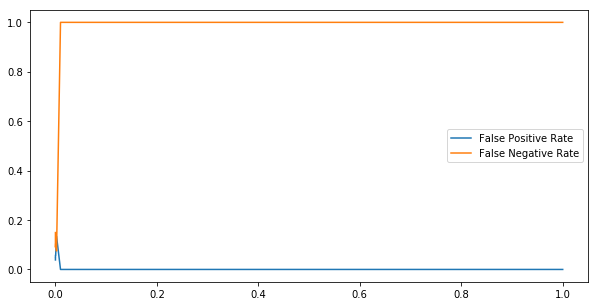


Normalized
Gamma		False Positive Rate	False Negative Rate
0.000001000	0.000000000		1.000000000
0.000004642	0.000000000		1.000000000
0.000021544	0.000000000		1.000000000
0.000100000	0.000000000		0.567164179
0.000464159	0.000000000		0.119402985
0.002154435	0.000000000		0.104477612
0.010000000	0.000000000		0.044776119
0.046415888	0.038461538		0.014925373
0.215443469	0.134615385		0.029850746
1.000000000	0.000000000		1.000000000
Best FPR: 0.000000000 at Gamma = 0.000001000
Best FNR: 0.014925373 at Gamma = 0.046415888


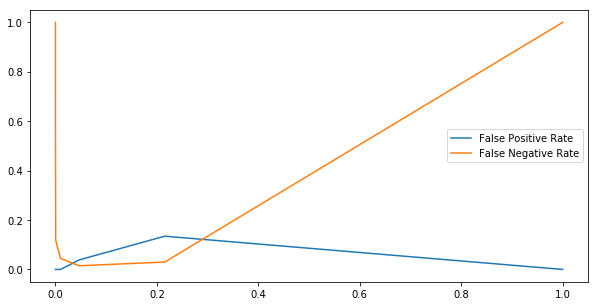

In [57]:
def rbfBruteForce(normalized = False):
    train_features = features_train_prepared if normalized else features_train
    test_features = features_test_prepared if normalized else features_test
    
    results = []

    gamma_range = np.logspace(-6, 0, num = 10)
    best_result = []
#     gamma_range = np.linspace(1e-6, 0.5, num = 25)

    print("Gamma\t\tFalse Positive Rate\tFalse Negative Rate")
    for gamma in gamma_range:
        clf = SVC(gamma = gamma)
        clf.fit(train_features, labels_train)

        labels_test_predicted = clf.predict(test_features)
        FPR, FNR = calculate_errors(labels_test, labels_test_predicted)
        results.append([gamma, FPR, FNR])
        print("%.09f\t%.09f\t\t%.09f" % (gamma, FPR, FNR))
        
    res_columns = list(zip(*results))
    gamma_col = res_columns[0]
    fpr_col = list(res_columns[1])
    fnr_col = res_columns[2]
    
    fpr_min_index = np.argmin(fpr_col)
    fnr_min_index = np.argmin(fnr_col)

    print("Best FPR: %.09f at Gamma = %.09f" % (fpr_col[fpr_min_index], 
                                               gamma_col[fpr_min_index]))
    
    print("Best FNR: %.09f at Gamma = %.09f" % (fnr_col[fnr_min_index], 
                                               gamma_col[fnr_min_index]))

    
    plt.figure(figsize=(10,5))
    plt.plot(gamma_col, fpr_col, label="False Positive Rate")
    plt.plot(gamma_col, fnr_col, label="False Negative Rate")
    plt.legend()
    plt.show()
    
print("Raw")
rbfBruteForce(normalized = False)

print("\nNormalized")
rbfBruteForce(normalized = True)

## Другие базовые решения

### Логистическая регрессия

In [24]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1')

fit_and_classify(clf)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.935672514619883
ERR1  0.04807692307692308
ERR2  0.08955223880597014


### Метод K ближайших соседей

In [25]:
# Метод k-ближайших соседей 
from sklearn.neighbors import  KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=5)
fit_and_classify(clf)

Accuracy: 0.9181286549707602
ERR1  0.057692307692307696
ERR2  0.11940298507462686


### Деревья решений

In [26]:
# деревья решений
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion="entropy", max_depth = 10000)
fit_and_classify(clf)

Accuracy: 0.9298245614035088
ERR1  0.09615384615384616
ERR2  0.029850746268656716


In [0]:
#нормировка - стандартизация
print(featuresTrainInit.shape)
mean = featuresTrainInit.mean(0)
std = featuresTrainInit.std(0)
print(mean.shape)
#нормируем обучающую выборку
featuresTrain = np.zeros_like(featuresTrainInit)
for i in range(0,featuresTrainInit.shape[0]):
    featuresTrain[i,:]= (featuresTrainInit[i,:]-mean)/std

(398, 30)
(30,)


### Метод главных компонент

(398, 14)


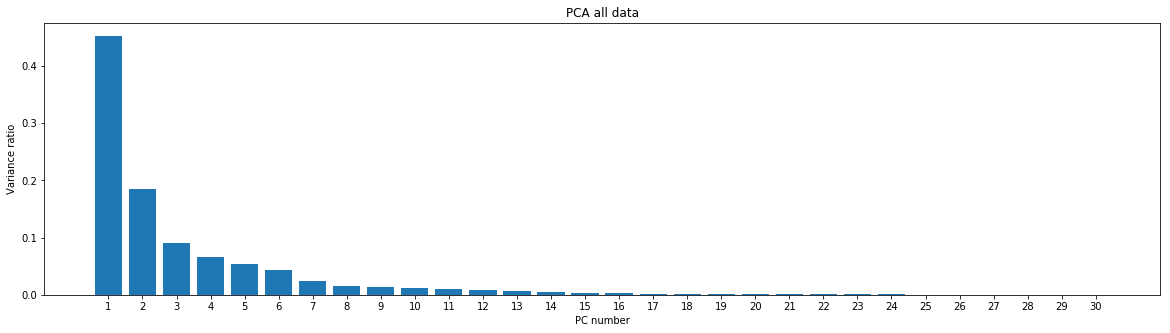

In [0]:
#метод главных компонент
from sklearn.decomposition import PCA
flen = featuresTrain.shape[1]
pca = PCA(n_components=flen)
pca.fit(featuresTrain)
plt.figure(figsize=(20,5))
plt.bar(np.arange(1,flen+1), pca.explained_variance_ratio_ ,tick_label=np.arange(1,flen+1))
plt.ylabel("Variance ratio")
plt.xlabel("PC number")
plt.title("PCA all data")
pca = PCA(n_components=14)
pca.fit(featuresTrain)
#преобразуем обучающую выборку
featuresTrain = pca.transform(featuresTrain)
print(featuresTrain.shape)

In [0]:
#нормируем и преобразуем с помощью PCA тестовую выборку на основе сохраненный mean, std, pca
print(featuresTestInit.shape)
featuresTest  =np.zeros_like(featuresTestInit)
for i in range(0,featuresTestInit.shape[0]):
    featuresTest[i,:]= (featuresTestInit[i,:]-mean)/std
print(featuresTest.shape)
featuresTest = pca.transform(featuresTest)

(171, 30)
(171, 30)


In [0]:
print(featuresTest.shape)

(171, 14)


### SVM на нормированных признаках

In [30]:
clf = svm.SVC(kernel = 'linear')
clf.fit(features_train_prepared, labelsTrain)
labels_test_predicted = clf.predict(features_test)
print_errors(labels_test, labels_test_predicted)

Accuracy: 0.391812865497076
ERR1  1.0
ERR2  0.0


(1.0, 0.0)

### Случайный лес на исходных и нормированных признаках

In [31]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=0)
print("Normalized")
clf.fit(features_train_prepared, labelsTrain)
labels_test_predicted = clf.predict(features_test)
print_errors(labels_test, labels_test_predicted)

print("\nRaw")
clf.fit(features_train, labelsTrain)
labels_test_predicted = clf.predict(features_test)
print_errors(labels_test, labels_test_predicted)

Normalized
Accuracy: 0.391812865497076
ERR1  1.0
ERR2  0.0

Raw
Accuracy: 0.9532163742690059
ERR1  0.038461538461538464
ERR2  0.05970149253731343


(0.038461538461538464, 0.05970149253731343)

### LASSO с выбором признаков 

[-0.         -0.00694104  0.         -0.00050193  0.          0.
  0.          0.          0.          0.          0.          0.
  0.0131634   0.          0.          0.          0.          0.
  0.          0.          0.06721442  0.01740661  0.0137029  -0.00048583
  0.          0.          0.01657663  0.          0.          0.        ]
Accuracy: 0.8947368421052632
ERR1  0.15384615384615385
ERR2  0.029850746268656716


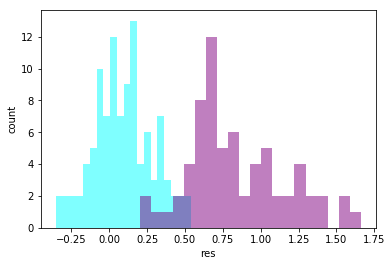

In [0]:
# LASSO с выбором признаков 
from sklearn.linear_model import Lasso
clf = Lasso(alpha=0.01)
clf.fit(featuresTrainInit, labelsTrain)
print(clf.coef_)

labelsPredict = clf.predict(featuresTestInit)

plt.figure()
plt.hist(labelsPredict[labelsTest==0],20, color='aqua', alpha=0.5, label='0')
plt.hist(labelsPredict[labelsTest==1],20, color='purple', alpha=0.5, label='1')
plt.xlabel('res')
plt.ylabel('count')
# plt.show()
labelAfterThresh = labelsPredict.copy()
labelAfterThresh[labelAfterThresh<0.3] = 0
labelAfterThresh[labelAfterThresh>=0.3] = 1
printErrlabelsTest(labelsTest,labelAfterThresh)


### SVM с kernel на синтетических линейно неразделимых данных

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linetypes'
  s)


[-3, 3, -3, 3]

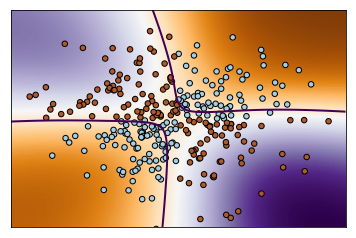

In [0]:
#SVM с kernel на синтетических линейно неразделимых данных
np.random.seed(0)
xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                     np.linspace(-3, 3, 500))

X = np.random.randn(300, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

# clf = svm.SVC(kernel = 'linear')
# clf = svm.SVC(kernel = 'rbf', gamma=0.4)
clf = svm.SVC(kernel = 'sigmoid', coef0=1.1)
clf.fit(X, Y)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
           origin='lower', cmap=plt.cm.PuOr_r)
contours = plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                       linetypes='--')
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap=plt.cm.Paired,
            edgecolors='k')
plt.xticks(())
plt.yticks(())
plt.axis([-3, 3, -3, 3])